# Анализ вакансий hh.ru

**Импортируем библиотеки, необходимые для работы**

In [1]:
import datetime
import os
import pandas as pd
import numpy as np
import itertools
import requests
from collections import Counter
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive, interactive, HTML

%matplotlib inline
pd.set_option("display.max_rows", 20, "display.max_columns", 60, 'mode.sim_interactive', True)

**Формируем словарь, где ключем является год, а значением путь к файлу с набором данных за этот год**

In [2]:
"""Файлы, которые вы загрузили с IEEE извлекать из архивов не нужно"""
datasets = {}
for file in os.listdir():
    file_reg = re.match(r"vacancies_[0-9]{4}.csv.gz", file)
    year_reg = re.search(r"[0-9]{4}", file)
    if file_reg:
        datasets[int(year_reg.group())] = file

## Предварительный просмотр структуры данных

**Выберем первые N строк, чтобы понять какие вообще есть данные**

In [3]:
"""количество строк, которое хотим скачать для предварительного просмотра"""
chunksize = 100
"""год за который хотим посмотреть данные"""
year = 2018
df = pd.read_csv(datasets[year], chunksize=chunksize, compression='gzip')
chunk_df = next(df)
chunk_df.head()

,id,description,key_skills,schedule_id,schedule_name,accept_handicapped,accept_kids,experience_id,experience_name,specializations,contacts,billing_type_id,billing_type_name,allow_messages,premium,driver_license_types,accept_incomplete_resumes,employer_id,employer_name,employer_vacancies_url,employer_trusted,employer_alternate_url,employer_industries,response_letter_required,type_id,type_name,has_test,response_url,test_required,salary_from,salary_to,salary_gross,salary_currency,archived,name,insider_interview,area_id,area_name,area_url,created_at,published_at,address_city,address_street,address_building,address_description,address_lat,address_lng,alternate_url,apply_alternate_url,code,department_id,department_name,employment_id,employment_name,prof_classes_found,terms_found
0,16398095,<p><strong>Netwrix Corporation </strong>- межд...,NaN,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,"1.221 Программирование, Разработка 1 Информаци...",NaN,standard,Стандарт,True,False,NaN,False,574211,Netwrix Corporation,https://api.hh.ru/vacancies?employer_id=574211,True,https://hh.ru/employer/574211,"Системная интеграция, автоматизации технологи...",False,open,Открытая,False,NaN,NaN,NaN,NaN,NaN,NaN,True,Программист С++ / С++ Developer,NaN,2,Санкт-Петербург,https://api.hh.ru/areas/2,2018-04-13T11:29:31+0300,2018-04-13T11:29:31+0300,Санкт-Петербург,Торфяная дорога,7,NaN,59.990690,30.260118,https://hh.ru/vacancy/16398095,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,programmer,кофе информационная_безопасность гибкий_график...
1,16399803,<p><strong>ООО «УЦСБ» – Уральский центр систем...,B2B Продажи\nАктивные продажи\nВедение перегов...,fullDay,Полный день,False,False,between1And3,От 1 года до 3 лет,"17.269 Телекоммуникации, Сетевые решения 17 Пр...",NaN,standard,Стандарт,True,False,NaN,False,662065,Уральский центр систем безопасности,https://api.hh.ru/vacancies?employer_id=662065,True,https://hh.ru/employer/662065,Разработка программного обеспечения\nСистемная...,False,open,Открытая,False,NaN,NaN,NaN,NaN,NaN,NaN,True,Менеджер по продажам,NaN,3,Екатеринбург,https://api.hh.ru/areas/3,2018-05-10T10:47:56+0300,2018-05-10T10:47:56+0300,Екатеринбург,улица Ткачей,23,NaN,56.816730,60.631916,https://hh.ru/vacancy/16399803,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,prodajnik,менеджер_по_продажам высшее_образование дружны...
2,28720019,<p>Ищем к себе в команду коллегу и единомышлен...,NaN,fullDay,Полный день,False,False,noExperience,Нет опыта,"17.269 Телекоммуникации, Сетевые решения 17 Пр...",NaN,standard,Стандарт,True,False,NaN,False,1898133,Волна мобайл (ООО КТК ТЕЛЕКОМ),https://api.hh.ru/vacancies?employer_id=1898133,True,https://hh.ru/employer/1898133,Мобильная связь,False,open,Открытая,False,NaN,NaN,NaN,NaN,NaN,NaN,True,Ведущий специалист контроля качества обслужива...,NaN,131,Симферополь,https://api.hh.ru/areas/131,2018-11-08T15:02:04+0300,2018-11-08T15:02:04+0300,NaN,NaN,NaN,NaN,NaN,NaN,https://hh.ru/vacancy/28720019,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,full,Полная занятость,specialist,team site nps мониторинг ms_office деловая_пер...
3,28720032,<p><strong>NETBYNET (бренд Wifire) ГК МегаФон ...,NaN,flexible,Гибкий график,False,False,noExperience,Нет опыта,1.203 Передача данных и доступ в интернет 1 Ин...,NaN,standard,Стандарт,True,False,B,False,43410,NETBYNET,https://api.hh.ru/vacancies?employer_id=43410,True,https://hh.ru/employer/43410,Интернет-провайдер,False,open,Открытая,False,NaN,NaN,NaN,NaN,NaN,NaN,True,Специалист по абонентским подключениям (ИП),NaN,2,Санкт-Петербург,https://api.hh.ru/areas/2,2018-11-16T10:22:50+0300,2018-11-16T10:22:50+0300,NaN,NaN,NaN,NaN,NaN,NaN,https://hh.ru/vacancy/28720032,https://hh.ru/applicant/vacancy_response?vacan...,NaN,NaN,NaN,part,Частичная занятость,specialist,utp уверенный_пользователь_пк опыт_работы
4,28720034,<p>Онлайн-кинотеатр ShowJet ищет в свою команд...,NaN,fullDay,Полный день,False,F

### Смотрим какие есть данные

In [4]:
chunk_df.columns

Index(['id', 'description', 'key_skills', 'schedule_id', 'schedule_name',
       'accept_handicapped', 'accept_kids', 'experience_id', 'experience_name',
       'specializations', 'contacts', 'billing_type_id', 'billing_type_name',
       'allow_messages', 'premium', 'driver_license_types',
       'accept_incomplete_resumes', 'employer_id', 'employer_name',
       'employer_vacancies_url', 'employer_trusted', 'employer_alternate_url',
       'employer_industries', 'response_letter_required', 'type_id',
       'type_name', 'has_test', 'response_url', 'test_required', 'salary_from',
       'salary_to', 'salary_gross', 'salary_currency', 'archived', 'name',
       'insider_interview', 'area_id', 'area_name', 'area_url', 'created_at',
       'published_at', 'address_city', 'address_street', 'address_building',
       'address_description', 'address_lat', 'address_lng', 'alternate_url',
       'apply_alternate_url', 'code', 'department_id', 'department_name',
       'employment_id', 'employ

Выберем информацию, которую хотим анализировать. Можно заменить элементы списка "use_cols" по своему усмотрению

In [5]:
use_cols = ['description', 'key_skills', 'schedule_name', 'experience_name', 'employer_name',
            'salary_from', 'salary_to', 'name', 'area_name', 'prof_classes_found', 'terms_found']

- **description** - полный текст описания вакансии
- **key_skills** - ключевые навыки необходимые для вакансии (появились лишь с 2015-го года)
- **schedule_name** - расписание: Полный день, Удаленная работа, Гибкий график, Сменный график, Вахтовый метод
- **experience_name** - необходимый опыт работы: Нет опыта, От 1 года до 3 лет, От 3 до 6 лет, Более 6 лет
- **employer_name** - название работодателя
- **salary_from** - нижняя граница заработной платы
- **salary_to** - верхняя граница заработной платы
- **name** - название вакансии
- **area_name** - наименование города, в котором опубликована вакансия
- **prof_classes_found** - укрупненная группа, к которой отнесено название вакансии
- **terms_found** - навыки найденные в поле **description**

## Найдем популярность профессий по годам (2010-2020)

In [6]:
period = 2010, 2021

In [7]:
def count_freq_by_year(df, year):
    """Функция считывает набор данных за указанный год и 
    возвращает количество вакансий за этот год по каждой профессии
    :param df: набор данных за указанный год
    :param year: год, за который осуществляется анализ
    :return: список профессий с их частотами за данный год в формате pandas data frame"""
    prof_by_class = df.prof_classes_found.fillna('').apply(str.split).values
    prof_list = itertools.chain.from_iterable(prof_by_class)
    count_profs = Counter(prof_list)
    sort_count_profs = sorted(count_profs.items(), key=lambda item: item[1], reverse=True)
    prof_with_freq = pd.DataFrame(sort_count_profs, columns=['Профессия', year])
    prof_with_freq = prof_with_freq.set_index('Профессия')
    return prof_with_freq

In [8]:
def visualization_stat(df, N=10):
    """Функция трансформирует набор данных
    и строит графики по переданной статистике
    :param df: набор данных со статистикой за переданные годы
    :param N: по умолчанию N = 10 - сколько наиболее частотных навыков требуется вывести на график
    :return: строит график"""
    
    """Найдем значение 1% количества вакансий за каждый год"""
    one_percent = df.sum(axis=0) / 100
    """Найдем частоту встречаемости каждой профессии за каждый год в процентном выражении"""
    df_per = df / one_percent
    """Выберем N наиболее часто встречаемых профессий и построим график"""
    
    for_plot = df_per[:N].transpose()
    for_plot.plot(figsize=(15,10))
    plt.legend(loc='right')

In [9]:
%%time
df = pd.DataFrame()
use_cols = ['prof_classes_found']
for year in range(*period):
    df = pd.concat([df,
                    count_freq_by_year(pd.read_csv(datasets[year], 
                                                   usecols=use_cols, 
                                                   compression='gzip'),
                                       year)],
                   axis=1)

CPU times: user 3min 36s, sys: 4.88 s, total: 3min 41s
Wall time: 16min 21s


**Приведем абсолютные значения частот к процентам**

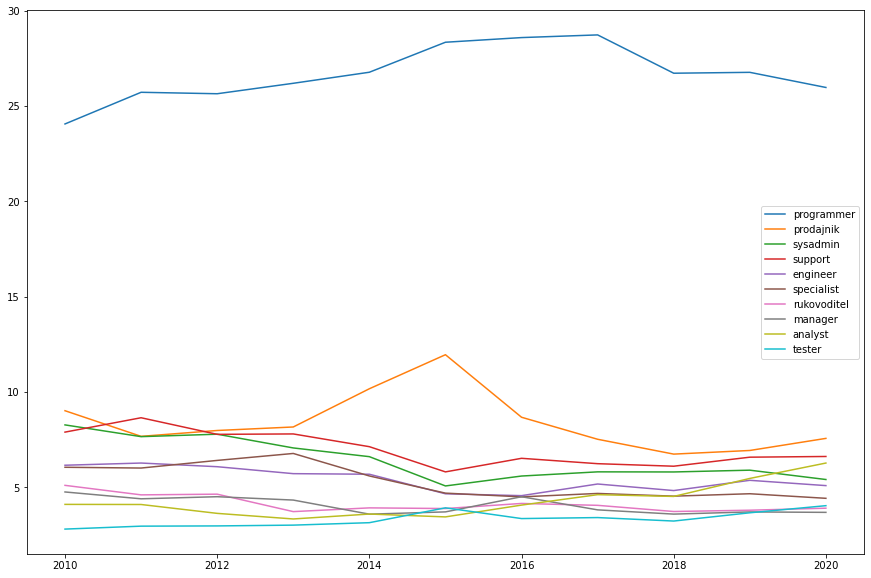

In [10]:
visualization_stat(df, N=10)

## Теперь давайте проанализируем частоты навыков по выбранной профессии

Выберем колонки, которые будем использовать

In [11]:
use_cols = ['prof_classes_found', 'terms_found']

**Сформируем навыки в группы по укрупненным областям**

In [12]:
skill_clasters = {}
with open("blocks.txt", 'r') as f:
    for line in f.readlines():
        line = line.strip('\n').split('/')
        key, values = line[0], line[1:]
        skill_clasters[key] = {k:None for k in values}
skill_clasters.keys()

dict_keys(['Языки программирования', 'Системы контроля версий', 'Базы данных', 'Операционные системы', 'Протоколы', 'Интерфейсы', 'Форматы', 'Фронтэнд', 'Бэкэнд', 'Фреймворки', 'Развёртывание ПО и виртуализация', 'Серверное ПО', 'Пакеты ПО', 'Утилиты', 'Библиотеки', 'RPC и интеграция', 'Сборка ПО', 'Среды разработки', 'Отладка', 'Мобильные платформы', 'Компании', 'Сервисы', 'CMS', 'Технологии', 'Сетевые технологии', 'Методологии и Процесс разработки', 'Модели ведения бизнеса', 'Роды занятий', 'Сертификаты', 'Управление процессами и ресурсами предприятия', 'Управление людьми', 'Проектирование ПО', 'Проектирование БД', 'Проектирование пользовательского интерфейса', 'Вёрстка', 'Тестирование', 'Виды тестирования', 'Реклама', 'Нотации', 'Документирование', 'Оптимизация', 'Поддержка', 'Игровые платформы', 'Архитектуры', 'Безопасность', 'Аналитика', 'Математика', 'Бухгалтерия', 'Администрирование', 'Шины', 'Бизнес-термины', '*Места', 'Образование', 'Квалификации', 'Обучение', 'Требования', 'У

**Расширим навыки синонимами**

In [13]:
def make_synonims(skill_group):
    """Функция формирует набор синонимов для каждого навыка
    :param skill_group: словарь по указанной укрупненной группе навыков
    :return: тот же словарь, но значения, которого заполнены синонимами слова-ключа"""
    lines = []
    with open("synonims.txt", 'r') as f:
        for line in f.readlines():
            line = line.strip('\n').split('/')
            lines.append(line)
    for key in skill_group.keys():
        for line in lines:
            if key in line:
                skill_group[key] = line
                break
        else:
            skill_group[key] = key
    return skill_group

In [14]:
def count_freq_skill_by_year(df, year, use_prof, skill_group):
    """Функция считывает набор данных за указанный год и 
    возвращает количество требований каждого навыка за указанный год
    :param df: набор данных за указанный год
    :param year: год, за который осуществляется анализ
    :param use_prof: профессия, по которой проводим анализ
    :return: список навков с их частотами за данный год в формате pandas data frame"""
    df.dropna(inplace=True)
    df.prof_classes_found = df.prof_classes_found.apply(lambda r: r if use_prof in r else None)
    df.dropna(inplace=True)
    df.drop('prof_classes_found', axis=1, inplace=True)
    
    terms_by_class = df.terms_found.fillna('').apply(str.split).values
    term_list = itertools.chain.from_iterable(terms_by_class)
    def search_synonim(skill, skill_group=skill_group):
        for k, v in skill_group.items():
            if skill in v:
                return k
        return 0
    term_list = map(search_synonim, term_list)
    term_list = filter(lambda x: x != 0, term_list)
    
    count_terms = Counter(term_list)
    sort_count_terms = sorted(count_terms.items(), key=lambda item: item[1], reverse=True)
    term_with_freq = pd.DataFrame(sort_count_terms, columns=['Навык', year])
    term_with_freq = term_with_freq.set_index('Навык')
    return term_with_freq

In [15]:
def analysi_by_year(use_prof, skill_group, period):
    """Функция выполняет анализ наборов данных по указанной профессии
    и указанной группе навыков. Возвращает статистику по годам
    :param use_prof: профессия, для которой выполняем анализ
    :param skill_group: группа навыков, по которой выполняем анализ
    :param period: период, за который выполняем анализ
    :return: список навков с их частотами за указанные годы в формате pandas data frame"""
    df = pd.DataFrame()
    for year in range(*period):
        df = pd.concat([df,
                        count_freq_skill_by_year(pd.read_csv(datasets[year], 
                                                             usecols=use_cols, 
                                                             compression='gzip'),
                                                 year,
                                                 use_prof,
                                                 skill_group
                                                 )],
                        axis=1)
    return df

### Проведем анализ по языкам программирования

In [16]:
%%time
use_prof = 'programmer'
need_skill = 'Языки программирования'
skill_group = skill_clasters[need_skill]
skill_group = make_synonims(skill_group)
prog_lang = analysi_by_year(use_prof, skill_group, period)

CPU times: user 2min 46s, sys: 2.6 s, total: 2min 49s
Wall time: 5min 7s


**Приведем абсолютные значения частот к процентам**

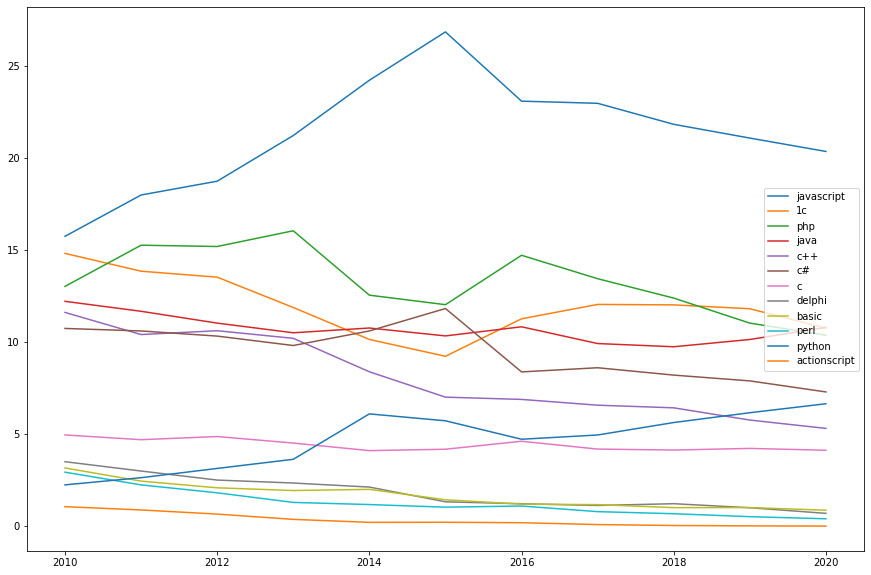

In [17]:
visualization_stat(prog_lang, N=12)

### Проведем анализ по системам контроля версий

In [18]:
%%time
need_skill = 'Системы контроля версий'
skill_group = skill_clasters[need_skill]
skill_group = make_synonims(skill_group)
version_control = analysi_by_year(use_prof, skill_group, period)

CPU times: user 1min 46s, sys: 1.48 s, total: 1min 47s
Wall time: 1min 47s


**Приведем абсолютные значения частот к процентам**

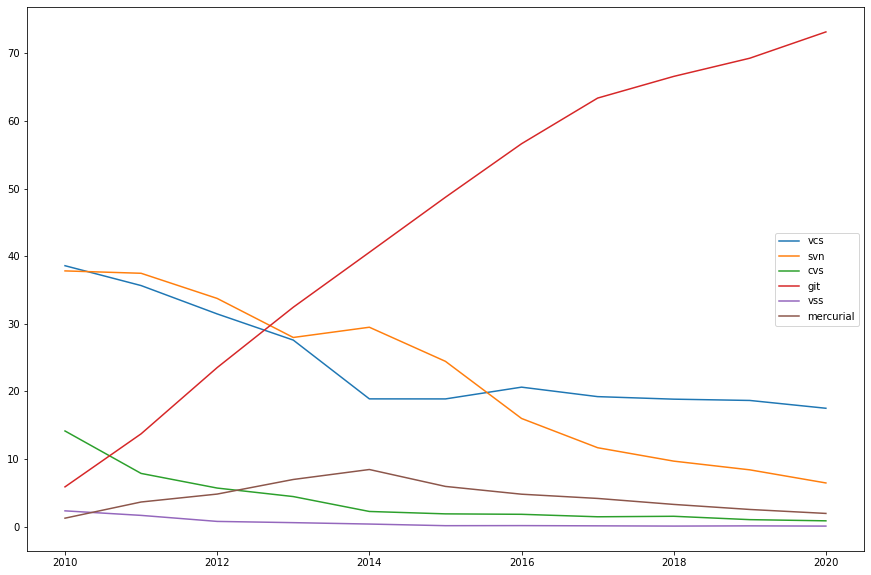

In [19]:
visualization_stat(version_control, N=10)

### Проведем анализ по базам данных

In [20]:
%%time
need_skill = 'Базы данных'
skill_group = skill_clasters[need_skill]
skill_group = make_synonims(skill_group)
bd = analysi_by_year(use_prof, skill_group, period)

CPU times: user 2min 28s, sys: 1.44 s, total: 2min 29s
Wall time: 2min 29s


**Приведем абсолютные значения частот к процентам**

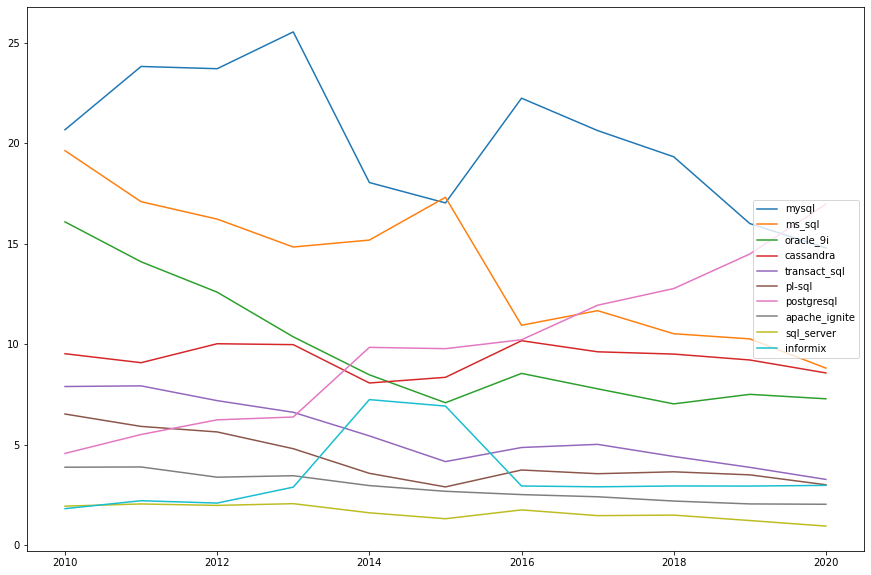

In [21]:
visualization_stat(bd, N=10)